In [1]:
from __future__ import print_function, division, absolute_import

from six.moves.urllib.request import urlretrieve
from six.moves import cPickle as pickle

In [2]:
import os, sys, warnings
import time
import ntpath

import tarfile

import imageio

from collections import deque
from joblib import Parallel, delayed

import numpy as np

from IPython.display import display, Image

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics.classification import accuracy_score

In [3]:
from matplotlib import pyplot as plt
%matplotlib inline 

### Downloading the data

In [4]:
url = 'https://commondatastorage.googleapis.com/books1000/'
data_root = 'data'
last_percent = None
def download_progress(count, block_size, total_size):
    global last_percent
    percent = count*block_size*100 // total_size
    if last_percent != percent:
        if percent %5 == 0:
            sys.stdout.write("%s%%"%percent)
            sys.stdout.flush()
        else:
            sys.stdout.write("~")
            sys.stdout.flush()
    last_percent = percent

def maybe_download(filename, force=False):
    if not os.path.exists(data_root):
        os.mkdir(data_root)
    dest_filename = os.path.join(data_root, filename)
    if force or not os.path.exists(dest_filename):
        print("Downloading:", filename)
        filename, _ = urlretrieve(url+filename, dest_filename, reporthook=download_progress)
        print("\nDownload complete!")
    return os.path.join(data_root, filename)

In [5]:
def maybe_extract(filename, force=False):
    filename_raw = os.path.splitext(os.path.splitext(filename)[0])[0]  # remove .tar.gz
    print(filename_raw)
    if os.path.isdir(filename_raw) and not force:
        print("{0} exists, Skipping extraction.".format(filename_raw))
    else:
        # data_root = os.path.dirname(os.path.splitext(os.path.splitext(test_filename)[0])[0])
        with tarfile.open(filename) as tar:
            tar.extractall(data_root)
    data_folders = [os.path.join(filename_raw, d) for d in sorted(os.listdir(filename_raw))
    if os.path.isdir(os.path.join(filename_raw, d))]
    return data_folders

In [6]:
train_filename = maybe_download("notMNIST_large.tar.gz",)
test_filename = maybe_download("notMNIST_small.tar.gz")

In [7]:
train_filename, test_filename

('data/notMNIST_large.tar.gz', 'data/notMNIST_small.tar.gz')

In [8]:
train_folders = maybe_extract(train_filename)
test_folders = maybe_extract(test_filename)
train_folders, test_folders

data/notMNIST_large
data/notMNIST_large exists, Skipping extraction.
data/notMNIST_small
data/notMNIST_small exists, Skipping extraction.


(['data/notMNIST_large/A',
  'data/notMNIST_large/B',
  'data/notMNIST_large/C',
  'data/notMNIST_large/D',
  'data/notMNIST_large/E',
  'data/notMNIST_large/F',
  'data/notMNIST_large/G',
  'data/notMNIST_large/H',
  'data/notMNIST_large/I',
  'data/notMNIST_large/J'],
 ['data/notMNIST_small/A',
  'data/notMNIST_small/B',
  'data/notMNIST_small/C',
  'data/notMNIST_small/D',
  'data/notMNIST_small/E',
  'data/notMNIST_small/F',
  'data/notMNIST_small/G',
  'data/notMNIST_small/H',
  'data/notMNIST_small/I',
  'data/notMNIST_small/J'])

In [9]:
letters="ABCDEFGHIJ"
for l in letters:
    img_path = os.path.join(data_root, "notMNIST_small", l)
    img_name = np.random.choice(os.listdir(img_path))
    display(Image(filename=os.path.join(img_path,img_name)))

### Image2Tensors

In [10]:
image_size = 28
pixel_depth = 255

In [11]:
def get_image_data(folder, image_name, normalization_factor):
    image_file = os.path.join(folder,image_name)
    normalizer = lambda x, normalization_factor: (x-normalization_factor)/normalization_factor
    try:
        image_data_raw = imageio.imread(image_file).astype(float)
    except Exception as e:
        print("ERROR READING {}".format(image_file),e)
        return "<INVALID>"
    image_data = normalizer(image_data_raw, normalization_factor)
    if image_data.shape != (image_size, image_size):
        warnings.warn("Unexpected image shape: {}".format(image_data.shape))
        return "<INVALID>"
    else:
        return image_data


def load_letter(folder, min_num_images, parallel=True, normalize=True):
    """Loading the data for a single letter label"""
    image_files = os.listdir(folder)
    normalization_factor = (pixel_depth+1)//2
    print(folder, normalization_factor)
    if parallel:
        images = Parallel(n_jobs=-1)(delayed(get_image_data)(
            folder, image_name, normalization_factor)for image_name in image_files)
        images = [i for i in images if type(i)!=str]
    else:
        images = deque(maxlen=len(image_files))
        normalizer = lambda x, normalization_factor: (x-normalization_factor)/normalization_factor
        for image_name in image_files:
            image_file = os.path.join(folder,image_name)
            try:
                image_data_raw = imageio.imread(image_file).astype(float)
            except Exception as e:
                print("Couldn't read {}".format(image_file), e)
                continue
            if normalize:
                image_data = normalizer(image_data_raw, normalization_factor)
            else:
                image_data = image_data_raw
            if image_data.shape != (image_size, image_size):
                warnings.warn("Unexpected image shape: {}".format(image_data.shape))
                continue
            else:
                images.append(image_data)
    
    if len(images)<min_num_images:
        raise Exception("Minimum number of instances is {0}. Got {1} instead.".format(min_num_images, len(images)))
    dataset = np.ndarray(shape=(len(images), image_size, image_size))
    
    for i in range(len(images)):
        dataset[i, :, :] = images[i]
    print("Full dataset tensor:", dataset.shape)
    print("Mean:", np.mean(dataset))
    print("Standar deviation:", np.std(dataset))
    return dataset

In [12]:
def pickle_folder_data(folder, min_num_images_per_class, force):
    set_filename = "{}.pickle".format(folder)
    if not force and os.path.exists(set_filename):
        print("{} already exists. Skipping pickling".format(set_filename))
    else:
        dataset = load_letter(folder, min_num_images_per_class, parallel=False)
        try:
            with open(set_filename,"wb") as f:
                pickle.dump(dataset, f)
        except Exception as e:
            print("Unable to save {}".format(set_filename), e)
            return
    return set_filename

def maybe_pickle(data_folders, min_num_images_per_class, force=False):
    dataset_names = Parallel(n_jobs=-1)(delayed(pickle_folder_data)(
        folder, min_num_images_per_class, force)for folder in data_folders)
    return dataset_names

In [13]:
train_datasets = maybe_pickle(train_folders, 45000)

data/notMNIST_large/B 128
data/notMNIST_large/A 128
data/notMNIST_large/C 128
data/notMNIST_large/D 128
data/notMNIST_large/H 128
data/notMNIST_large/F 128
data/notMNIST_large/G 128
data/notMNIST_large/E 128
Couldn't read data/notMNIST_large/A/RnJlaWdodERpc3BCb29rSXRhbGljLnR0Zg==.png Could not find a format to read the specified file in mode 'i'
Couldn't read data/notMNIST_large/A/SG90IE11c3RhcmQgQlROIFBvc3Rlci50dGY=.png Could not find a format to read the specified file in mode 'i'
Couldn't read data/notMNIST_large/D/VHJhbnNpdCBCb2xkLnR0Zg==.png Could not find a format to read the specified file in mode 'i'
Couldn't read data/notMNIST_large/A/Um9tYW5hIEJvbGQucGZi.png Could not find a format to read the specified file in mode 'i'
Couldn't read data/notMNIST_large/B/TmlraXNFRi1TZW1pQm9sZEl0YWxpYy5vdGY=.png Could not find a format to read the specified file in mode 'i'
Full dataset tensor: (52912, 28, 28)
Mean: -0.2873110004763878
Full dataset tensor: (52912, 28, 28)
Full dataset tensor:

In [14]:
test_datasets = maybe_pickle(test_folders, 1800)

data/notMNIST_small/C 128
data/notMNIST_small/B 128
data/notMNIST_small/A 128
data/notMNIST_small/G 128
data/notMNIST_small/F 128
data/notMNIST_small/H 128
data/notMNIST_small/E 128
data/notMNIST_small/D 128
Couldn't read data/notMNIST_small/F/Q3Jvc3NvdmVyIEJvbGRPYmxpcXVlLnR0Zg==.png Could not find a format to read the specified file in mode 'i'
Couldn't read data/notMNIST_small/A/RGVtb2NyYXRpY2FCb2xkT2xkc3R5bGUgQm9sZC50dGY=.png Could not find a format to read the specified file in mode 'i'
Full dataset tensor: (1872, 28, 28)
Full dataset tensor: (1873, 28, 28)
Mean: -0.1232676994065779
Mean: -0.12082624077776143
Full dataset tensor: (1873, 28, 28)
Mean: -0.10195507967852785
Standar deviation: 0.9139338288341073
Full dataset tensor: (1872, 28, 28)
Full dataset tensor: (1872, 28, 28)
Standar deviation: 0.9111262733434989
Mean: -0.2681228368876597
Mean: -0.239353586486678
Standar deviation: 0.9159260080119535
data/notMNIST_small/I 128
Full dataset tensor: (1872, 28, 28)
Full dataset tens

In [15]:
train_datasets

['data/notMNIST_large/A.pickle',
 'data/notMNIST_large/B.pickle',
 'data/notMNIST_large/C.pickle',
 'data/notMNIST_large/D.pickle',
 'data/notMNIST_large/E.pickle',
 'data/notMNIST_large/F.pickle',
 'data/notMNIST_large/G.pickle',
 'data/notMNIST_large/H.pickle',
 'data/notMNIST_large/I.pickle',
 'data/notMNIST_large/J.pickle']

In [16]:
test_datasets

['data/notMNIST_small/A.pickle',
 'data/notMNIST_small/B.pickle',
 'data/notMNIST_small/C.pickle',
 'data/notMNIST_small/D.pickle',
 'data/notMNIST_small/E.pickle',
 'data/notMNIST_small/F.pickle',
 'data/notMNIST_small/G.pickle',
 'data/notMNIST_small/H.pickle',
 'data/notMNIST_small/I.pickle',
 'data/notMNIST_small/J.pickle']

In [17]:
labels_dict = dict()

def merge_datasets(pickle_files, train_size=0.8, validation_size=0.1):
    datasets = deque()
    labels = deque()
    for f in pickle_files:
        label = ntpath.basename(f).split(".")[0]
        labels_dict.setdefault(label, len(labels_dict))
        
        dataset = pickle.load(open(f,'rb'))
        datasets.append(dataset)
        labels.append(np.ones(len(dataset))*labels_dict[label])
    datasets = np.concatenate(datasets, axis=0)
    labels = np.concatenate(labels, axis=0)
    print("Dataset shape is: {0}\nLabels shape is: {1}".format(datasets.shape, labels.shape))
    
    permutation = np.random.permutation(len(datasets))
    return datasets[permutation,:,:], labels[permutation]

In [18]:
train_X, train_y = merge_datasets(train_datasets)
test_X, test_y = merge_datasets(test_datasets)

Dataset shape is: (529114, 28, 28)
Labels shape is: (529114,)
Dataset shape is: (18724, 28, 28)
Labels shape is: (18724,)


In [44]:
pickle_file = os.path.join(data_root, 'notMNIST.pickle')
try:
    with open(pickle_file, 'wb') as f:
        pickle.dump({
            "train_X":train_X,
            "train_y":train_y,
            "test_X":test_X,
            "test_y":test_y,
            "labels_dict":labels_dict
        }, f)
except Exception as e:
    print("Could save the dataset: ",e)

In [45]:
statinfo = os.stat(pickle_file)
print('Compressed pickle size:', statinfo.st_size)

Compressed pickle size: 3440423111


In [22]:
train_X = np.array([i.flatten() for i in train_X])
test_X = np.array([i.flatten() for i in test_X])
print(train_X.shape, test_X.shape)

(529114, 784) (18724, 784)


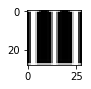

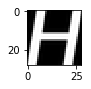

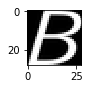

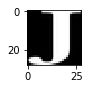

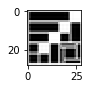

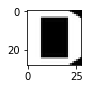

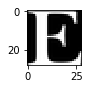

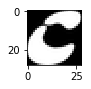

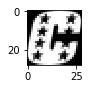

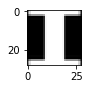

In [24]:
for i in range(10):
    plt.figure(figsize=(1,1))
    img_mat = train_X[np.random.choice(range(len(train_X)-1))].reshape(image_size, image_size)
    plt.imshow(img_mat, cmap='gray')
    plt.show()